# **Optimization for Data Science**

### Homework 1 

Group members (ID number):
- 2092227
- 2072251
- 2096999 
- 2097154

### **The comparison of Gradient Descent and Block Coordinate Descent Methods(Randomized and Gauss-Southwell)**

The goal of the optimization problem is to find the labels {-1, 1} for the dataset of group one, which initially has no labels. This is done in a way that maximizes the similarity within the group and at the same time maximizes the similarity with the dataset of group two, which already has true labels {1, -1}. More precisely, we want to find a labeling that best satisfies these two objectives simultaneously. in fact, we want to minimize the following equation:

$f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2$

To utilize the gradient descent method, we need to compute the first derivative of the objective function, and to compute the Lipschitz constant, we need the second derivative, which is used to calculate the Hessian matrix(we have use Lipschitz constant as our learning rate). However, computing the Hessian matrix can be computationally expensive, especially for large datasets. In our case, since the dataset is not very large, we were able to compute the Hessian matrix, but this may not always be the best option.


$f'(y) = 2 \sum_{i=0}^l \sum_{j=0}^u w_{ij}(y^j - \bar{y}^i) - \sum_{i=0}^u \sum_{j=0}^u \bar{w}_{ij}(y^j - y^i)$









#**Part 1**

## *Inizialization*

Load necessary libraries

In [2]:
import sklearn.datasets
from sklearn.preprocessing import MinMaxScaler

import math
import random 

import pandas as pd
import matplotlib.pyplot as plt

import scipy.linalg
import numpy as np
from numpy import dot
from numpy.linalg import norm


from timeit import default_timer as timer

Generate labeled points then plot them

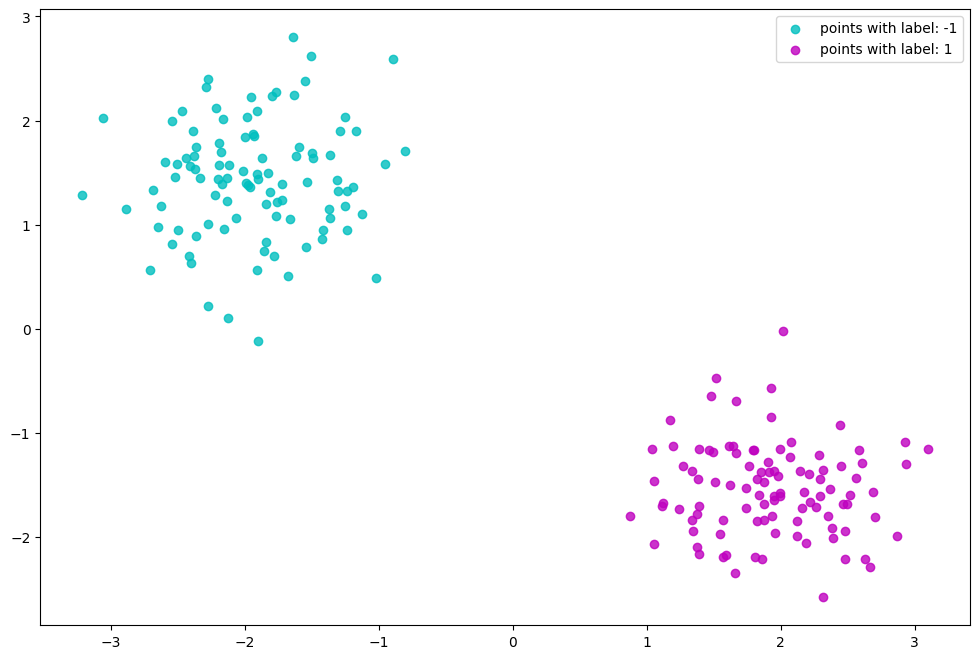

In [3]:
# Number of points with label
n_samples = 200

X_label, y_label = sklearn.datasets.make_blobs(n_samples=n_samples, n_features=2, cluster_std=0.5, 
                            centers=[[-2,1.5],[2,-1.5]], random_state=123)

# Converting labels to [-1,+1] 
y_label[y_label[:] == 0] = -1

# Plotting the points
fig, ax = plt.subplots(figsize=(12,8))
scatter1 = ax.scatter(X_label[y_label == -1][:, 0], X_label[y_label == -1][:, 1], c = 'c', alpha=0.8, label='points with label: -1')
scatter2 = ax.scatter(X_label[y_label == 1][:, 0], X_label[y_label == 1][:, 1], c = 'm', alpha=0.8, label='points with label: 1')
ax.legend(loc='upper right')
plt.show()

Generate unlabeled points then plot them with the labeled ones

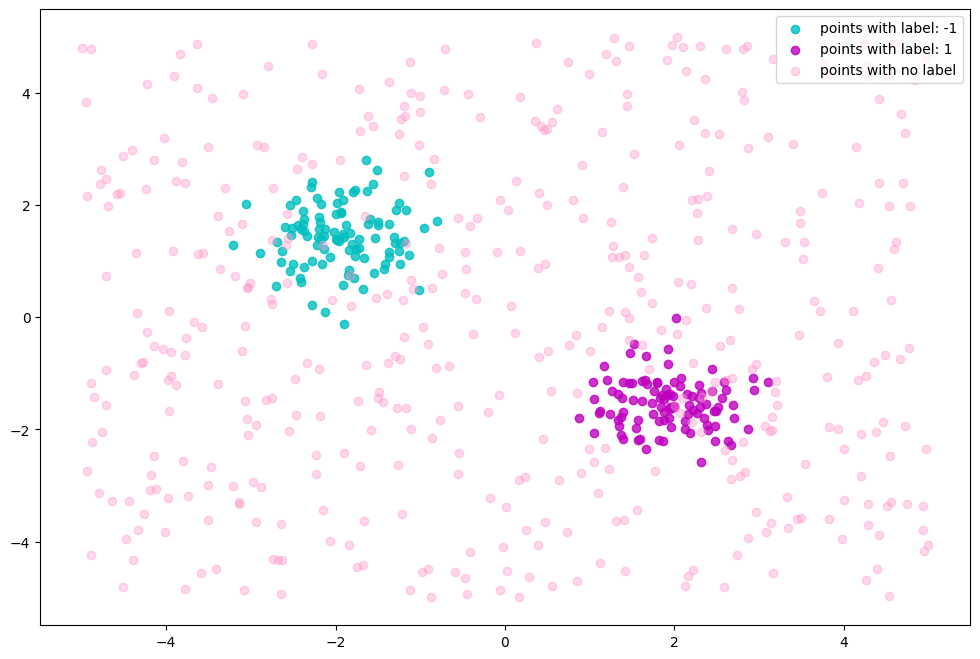

In [4]:
# Setting seed for reproducibility
np.random.seed = 123

# Number of points with no-label
unlabel_point= 450

X_unlabel = [np.random.uniform(-5, 5,2) for i in range(unlabel_point)]

# Converting the list into an array    
X_unl = np.array(X_unlabel)

# Plotting all the points
fig, ax = plt.subplots(figsize=(12,8))
sct_1 = ax.scatter(X_label[y_label == -1][:, 0], X_label[y_label == -1][:, 1], c = 'c', alpha=0.8, label='points with label: -1')
sct_2 = ax.scatter(X_label[y_label == 1][:, 0], X_label[y_label == 1][:, 1], c = 'm', alpha=0.8, label='points with label: 1')
sct_3 = ax.scatter(X_unl[:,0], X_unl[:,1], c = "#FF99CC", alpha=0.4, label='points with no label')
ax.legend(loc='upper right')
plt.show()

To measure the similarity between the points in Group 1 and the labeled points in Group 2, we utilized cosine similarity. This was accomplished by creating two matrices: W_unl_unl, which represents the cosine similarity between the unlabeled points in Group 1, and W_lbl_unl, which represents the cosine similarity between the labeled points in Group 2 and the unlabeled points in Group 1.

Define similarity mesaure

In [5]:
# We have chosen the "cosine similarity"
def cos_sim(a, b):
  return dot(a, b)/(norm(a)*norm(b))


Compute matrix similarity between unlabeled points 

In [6]:
# Matrix of similarities between unlabeled points
def Sim_unl_unl(X_unl):
  W_unl_unl = np.zeros((len(X_unl), len(X_unl)))

  for i in range(len(X_unl)):
    for j in range(len(X_unl)):
      W_unl_unl[i][j] = cos_sim(X_unl[i], X_unl[j])
  return W_unl_unl



In [7]:
W_unl_unl = Sim_unl_unl(X_unl)
print("Matrix of similarities between unlabeled points")
print("Shape: ", W_unl_unl.shape)  

Matrix of similarities between unlabeled points
Shape:  (450, 450)


Compute matrix similarity between labeled points and unlabeled ones

In [8]:
# Matrix of similarities between labeled and unlabeled points
def Sim_lbl_unl(X_label,X_unl):
  W_lbl_unl = np.zeros((len(X_label), len(X_unl)))

  for i in range(len(X_label)):
    for j in range(len(X_unl)):
      W_lbl_unl[i][j] = cos_sim(X_label[i], X_unl[j])
  return W_lbl_unl


In [9]:
W_lbl_unl = Sim_lbl_unl(X_label,X_unl) 
print("Matrix of similarities between labeled and unlabeled points")
print("Shape: ", W_lbl_unl.shape)

Matrix of similarities between labeled and unlabeled points
Shape:  (200, 450)


Assign random lables to unlabeled points then plot them with the labeled ones

In [10]:
def generate_Y(X_unl):
  # Assigning random labels to unlabeled points
  Y = np.zeros(len(X_unl))
  for i in range(len(X_unl)):
      Y[i] = random.randint(0, 1)

  # Converting labels to [-1,+1]
  Y[Y[:]==0] = -1
  return Y


In [11]:
def pltpoints(X_label,y_label,X_unl,Y):
  fig, ax = plt.subplots(figsize=(12,8))
  sct_1 = ax.scatter(X_label[y_label == -1][:, 0], X_label[y_label == -1][:, 1], c = 'c', alpha=0.8, label='points with label: -1')
  sct_2 = ax.scatter(X_label[y_label == 1][:, 0], X_label[y_label == 1][:, 1], c = 'm', alpha=0.8, label='points with label: 1')
  sct_3 = ax.scatter(X_unl[Y == -1][:,0], X_unl[Y == -1][:,1], c = '#3399FF', alpha=0.4, label='provisional points with label: -1')
  sct_4 = ax.scatter(X_unl[Y == 1][:,0], X_unl[Y == 1][:,1], c = '#FF007F', alpha=0.4, label='provisional points with label: 1')
  ax.legend(loc='upper right')
  plt.show()

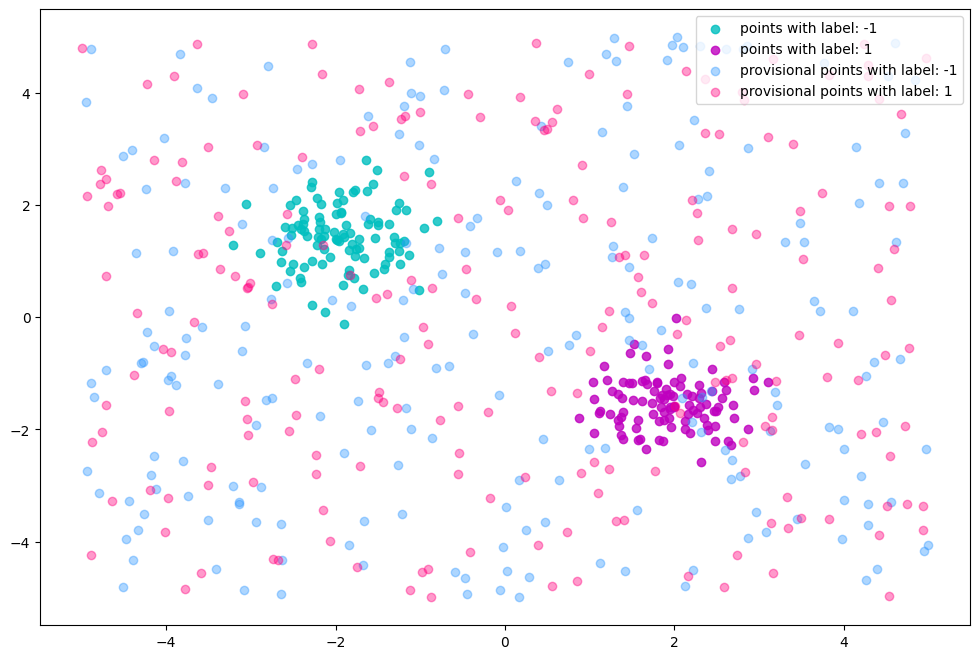

In [12]:
Y = generate_Y(X_unl)
# Plotting all the points
pltpoints(X_label,y_label,X_unl,Y)

Calculate the Hessian matrix, the sigma parameter and the Lipschitz constant

In [16]:
# Computing the hessian matrix
def hessianMat(W_unl_unl, W_lbl_unl):
    mat = np.copy(-W_unl_unl)
    for i in range(mat.shape[0]):
      mat[i][i] = np.sum(W_lbl_unl[:,i]) + np.sum(W_unl_unl[:,i]) - W_unl_unl[i][i]
    return mat * 2

# Computing the max eigvalue
def lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]



# **Gradient Descent Schemes**

*  minimize a differentiable function $f$ on $R^n$.
*  We use a linear (first order) approximation of $f(x_k + d)$ to calculate the search direction at each iteration.
* In practice, we approximate $f(x_k + d)$ with the function $η_k(d)$ defined as follows: $η_k(d) := f(x_k) + ∇f(x_k)^T d$.
* Then choose $d_k$ as the direction such that: 

  $min (η_k(d)),   ||d|| = 1$.

  Equivalent to $min(∇f(xk)^Td)$ , ||d|| = 1.

* Using the Cauchy-Schwarz inequality, we prove that the optimal
direction is $d^∗_k = −\frac{\nabla f(x_k)}{||f(x_k)||}$.
* The classic gradient method calculate each iterate as follows:
  $x_{k+1} = x_k − α˜ \frac{f(x_k)}{||f(x_k)||}$.
*By suitably redefining the stepsize $α_k := \frac{α˜}{||f(x_k)||}$,we then have $x_{k+1} = x_k − α_k ∇f(x_k)$.



***Algorithm 1 Gradient method***

> *1) Choose a point $x_1 ∈ R^n$*

> *2) For k = 1, . . .*

> *3) If x_k satisfies some specific condition, then STOP*

> *4) Set $x_{k+1} = x_k − α_k ∇f(x_k)$, with $α_k$ > 0 a stepsize*

> *5) End for*




***How to calculate the stepsize?***

*In optimization problems, choosing an appropriate step size is a crucial aspect for efficient and effective convergence. There are different methods available for computing the step size, including Armijo rule, line search, and fixed step size. In our implementation, we chose the fixed step size method as our learning rate because it is easy to implement and provided satisfactory results. To set the step size, we assigned the Lipschitz constant to it, which is proved to be a good choice for fixed step size.*

*The formula for the fixed step size can be written as:*

$α = 1/L,$

*where L is the Lipschitz constant of the gradient of the objective function. This fixed step size ensures that the algorithm moves toward the minimum point without oscillations or divergence. However, the Lipschitz constant is not always easy to compute and may require additional assumptions about the objective function.*



### ***How to compute the Lipschitz constant?***

*The Lipschitz constant of the gradient can be computed using the Hessian matrix of the objective function. The Hessian matrix is a matrix of second-order partial derivatives of the objective function and can be used to estimate the curvature of the function. The Lipschitz constant can be calculated as follows:*

* *Compute the Hessian matrix H(x) of the objective function f(x) at the point x.*

* *Compute the spectral norm of the Hessian matrix, which is the largest eigenvalue of the matrix.*

*The Lipschitz constant L of the gradient is equal to the spectral norm of the Hessian matrix, i.e., L = ||H(x)||.*

In [17]:
print("Calculating the Hessian matrix")
hessian = hessianMat(W_unl_unl, W_lbl_unl)
print("\nEstimating Lipschitz constant for the whole function")
L = lipschitz_constant(hessian)
print(f"Lipschitz constant: {L}")
print("\nEstimating Lipschitz constant for each single variable")
Li = np.array([norm(hessian[i][i]) for i in range(len(hessian))], dtype='float64') 

Calculating the Hessian matrix

Estimating Lipschitz constant for the whole function
Lipschitz constant: 35.347274906248636

Estimating Lipschitz constant for each single variable


Define loss and accuracy functions 

In [18]:
# Defining function to compute loss function and accuracy
def loss_fun(W_lbl_unl,W_unl_unl,y_label,y_unl): 

  # Creating a MinMaxScaler object
  y = np.copy(y_unl).reshape(-1,1)
  y_lbl = np.copy(y_label).reshape(-1,1)
  scaler = MinMaxScaler()

  # Fitting the scaler to your data
  scaler.fit(y)
  
  # Transforming the data into the range of [-1,1]
  y_scaled = scaler.fit_transform(y)
  
  y_scaled  = y_scaled.reshape(-1,1)
  
  #simply compute the given formula F(Y)
  first_part =np.power(y_scaled - y_lbl.T, 2) * W_lbl_unl.T
  second_part = np.power(y_scaled- y_scaled.T, 2) * W_unl_unl.T
  return (np.sum(first_part) + np.sum(second_part)/2)

def Accuracy(y,label):
  num = abs(label+y)/2
  return np.sum(num)/len(label)*100

## *Implementation of CLASSIC GRADIENT DESCENT ALGORITHM*


- **Stopping condition**: if all the components of the gradient array are below 
the tollerance (1e-10) or if we reached max iteration number (100)

- **Step size**: Lipschitz constant


In [20]:
def GD(W_lbl_unl,W_unl_unl,X_unl,Y,X_label,y_label,num=100):
  max_iter = num
  tolerance = 1e-10
  step_size = 0.3

  gradient = np.ones(len(X_unl))

  loss_stack = []
  acc_stack = []

  iter_count = 0
  y_unl = np.copy(Y)
  # Starting the algorithm
  start = timer()

  print('Starting algorithm\n')
  while (np.any(abs(gradient) > tolerance)) and (iter_count < max_iter):
    iter_count += 1

    # Computing the gradient array
    for j in range(len(X_unl)):
      
      part1 = np.dot(2* W_lbl_unl[:,j],(y_unl[j]-y_label[:]))
      part1 = part1/norm(2* W_lbl_unl[:,j]* (y_unl[j]-y_label[:]))

      part2 = np.dot(2* W_unl_unl[:,j],(y_unl[j]-y_unl[:]))
      part2 = part2/norm(2* W_unl_unl[:][j]* (y_unl[j]-y_unl[:]))

      gradient[j] = part1 + part2
      #update the parameters
      y_unl[j] = y_unl[j] - (1/L)*gradient[j]

    current_loss = loss_fun(W_lbl_unl,W_unl_unl,y_label,y_unl)
    loss_stack.append(current_loss)

    if iter_count % 10 == 0:
      print(f'--- iteration: {iter_count} --- loss: {np.round(current_loss,3)} ---')

  end = timer()

  exe_time_GD = end - start
  print(f"\nTime required: {(exe_time_GD)}")

  return y_unl,loss_stack,exe_time_GD

In [21]:
y_pred,loss_stack,exe_time_GD = GD(W_lbl_unl,W_unl_unl,X_unl,Y,X_label,y_label)

Starting algorithm

--- iteration: 10 --- loss: -60314.38 ---
--- iteration: 20 --- loss: -63620.362 ---
--- iteration: 30 --- loss: -64434.246 ---
--- iteration: 40 --- loss: -64724.23 ---
--- iteration: 50 --- loss: -64834.074 ---
--- iteration: 60 --- loss: -64880.364 ---
--- iteration: 70 --- loss: -64896.852 ---
--- iteration: 80 --- loss: -64898.219 ---
--- iteration: 90 --- loss: -64891.564 ---
--- iteration: 100 --- loss: -64880.586 ---

Time required: 2.699228409999705


Convert labels to [-1, +1] and plotting the loss function

In [28]:
# Rounding labels
def Rounding(y_unl):
  for y in range(len(y_unl)):
    if y_unl[y]>0 : y_unl[y]=1
    if y_unl[y]<0 : y_unl[y]=-1
  return y_unl

#Plotting the loss values
def loss_plot(loss):
  # Plotting the gradient through iterations
  plt.plot(np.arange(100), loss[0:100], marker='.', linewidth=1)

  # Add labels and title
  plt.xlabel('Iterations', fontsize=12)
  plt.ylabel('Loss Value', fontsize=12)
  plt.title('Gradient Descent Loss over Iterations', fontsize=14)

  # Add gridlines
  plt.grid(True)

  # Show plot
  plt.show()


Final Loss value: -64880.58628715736



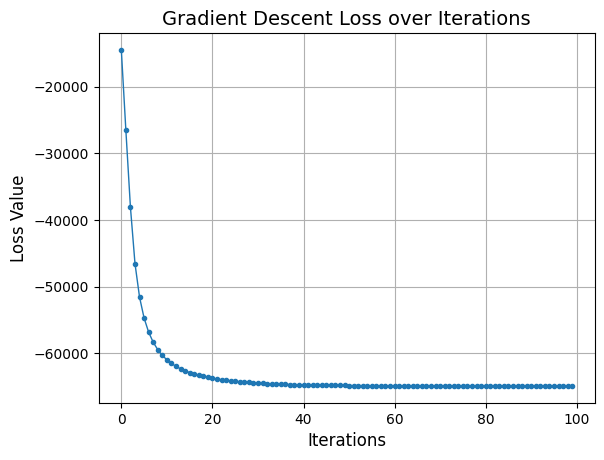

In [39]:
y_pred = Rounding(y_pred)
# Printing out the final gradient
print(f'Final Loss value: {loss_stack[-1]}\n')
loss_plot(loss_stack)

Replot all the points to see if the algorithm works

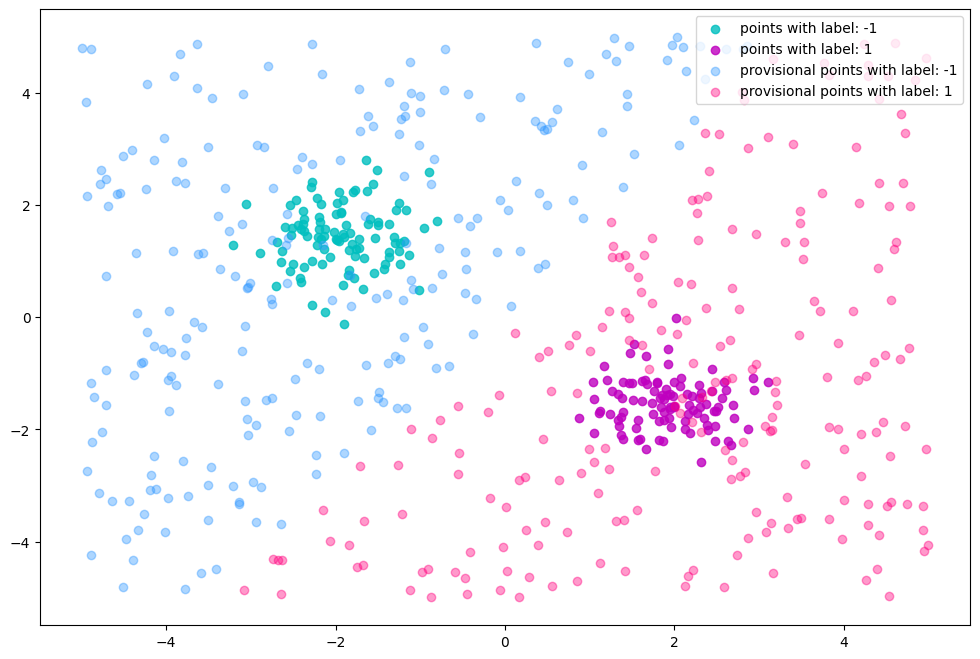

In [30]:
# Plotting all the points
pltpoints(X_label,y_label,X_unl,y_pred)


## *Implementation of BLOCK COORDINATE GRADIENT DESCENT with RANDOMIZED RULE* 

***Algorithm 2 Randomized BCGD method***

1) Choose a point $x_1 ∈ R^n$

2) For k = 1, . . .
3) If $x_k$ satisfies some specific condition, then STOP


4) Randomly pick $i_k ∈ {1, . . . , b}$

5) Set  $x_{k+1} = x_k - α_k U_{i_k}∇_{i_k} f(x_k)$

6) End for

We consider a uniform distribution to randomly pick the block.
Since $i_k$ is a discrete random variable we have that
$P(i_k = i) = \frac{1}{b}$, ∀ i = 1, . . . , b.
Keep in mind that the variables $i_1$, . . . , $i_k$ are all independent.

**Improving the Rate**

There exist different strategies to improve the rate of the randomized BCGD algorithm.
* First idea: use larger stepsizes (replace $α_k = \frac{1}{L}$ with $ α_k = \frac{1}{L_{i_k}}$).

* Second idea: use non-uniform sampling. Nesterov’s idea: use
  $P(i_k = i) = \frac{Li}{\sum^b _{i=1} Li}$
,
i.e. we choose block with larger Lipschitz constant more frequently.

**Stopping condition**: if all the components of the gradient array are below 
the tollerance (1e-10) or if we reached max iteration number (10000)

**Step size**: $ α_k = \frac{1}{L_{i_k}}$



In [32]:
def BCGD_R(W_lbl_unl,W_unl_unl,X_unl,Y,X_label,y_label,num=100):
  max_iter = num
  tolerance = 1e-10
  step_size = 0.3

  gradient = np.ones(len(X_unl))

  loss_stack_BCGDR = []
  acc_BCGD_R = []
  y_unl = np.copy(Y)
  iter_count = 0

  # The number of blocks is equal to len(y_unl)
  # Randomly select some block i with uniform probability 1/b to update (we only pick one block in this case).


  # Starting the algorithm
  start = timer()

  while (np.any(abs(gradient) > tolerance)) and (iter_count < max_iter):

    # Computing the gradient array
    iter_count +=1

    indexes =  np.random.choice(X_unl.shape[0],X_unl.shape[0],replace=False,p= np.copy(Li) / np.sum(Li))
    
    for i in range(X_unl.shape[0]):
      index = indexes[i]
      
      part1 = np.dot(2* W_lbl_unl[:,index],(y_unl[index]-y_label[:]))
      part1 = part1/norm(2* W_lbl_unl[:,index]* (y_unl[index]-y_label[:]))

      part2 = np.dot(2* W_unl_unl[:,index],(y_unl[index]-y_unl[:]))
      part2 = part2/norm(2* W_unl_unl[:][index]* (y_unl[index]-y_unl[:]))

      gradient[index] = part1 + part2
      y_unl[index] = y_unl[index] - (1/Li[index])*gradient[index]
    current_loss = loss_fun(W_lbl_unl,W_unl_unl,y_label,y_unl)
    loss_stack_BCGDR.append(current_loss)
    acc_BCGD_R.append(1- abs(current_loss))
    if iter_count % (10) == 0:
      print(f'--- iteration: {iter_count} --- loss: {np.round(current_loss,3)} ---')

    
  end =timer()

  exe_time_BCGD = end - start 
  print(f"Time required: {(exe_time_BCGD)}")

  return y_unl,loss_stack_BCGDR,exe_time_BCGD

In [33]:
y_unl,loss_stack_BCGDR,exe_time_BCGD = BCGD_R(W_lbl_unl,W_unl_unl,X_unl,Y,X_label,y_label)

--- iteration: 10 --- loss: -2365.284 ---
--- iteration: 20 --- loss: -3001.121 ---
--- iteration: 30 --- loss: -3303.549 ---
--- iteration: 40 --- loss: -3461.389 ---
--- iteration: 50 --- loss: -3552.479 ---
--- iteration: 60 --- loss: -3609.053 ---
--- iteration: 70 --- loss: -3646.382 ---
--- iteration: 80 --- loss: -3672.067 ---
--- iteration: 90 --- loss: -3690.477 ---
--- iteration: 100 --- loss: -3704.118 ---
Time required: 2.8410675909999554


Convert labels to [-1, +1] and plotting the gradient behaviour

Final Loss value: -3704.117821028831



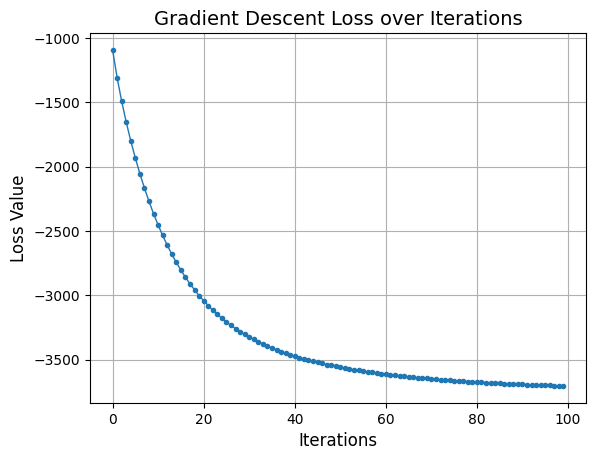

In [40]:
y_pred_R = Rounding(y_unl)
print(f'Final Loss value: {loss_stack_BCGDR[-1]}\n')
# Plotting the gradient throught iteration1
loss_plot(loss_stack_BCGDR[0:100])


Replot all the points to see if the algorithm works

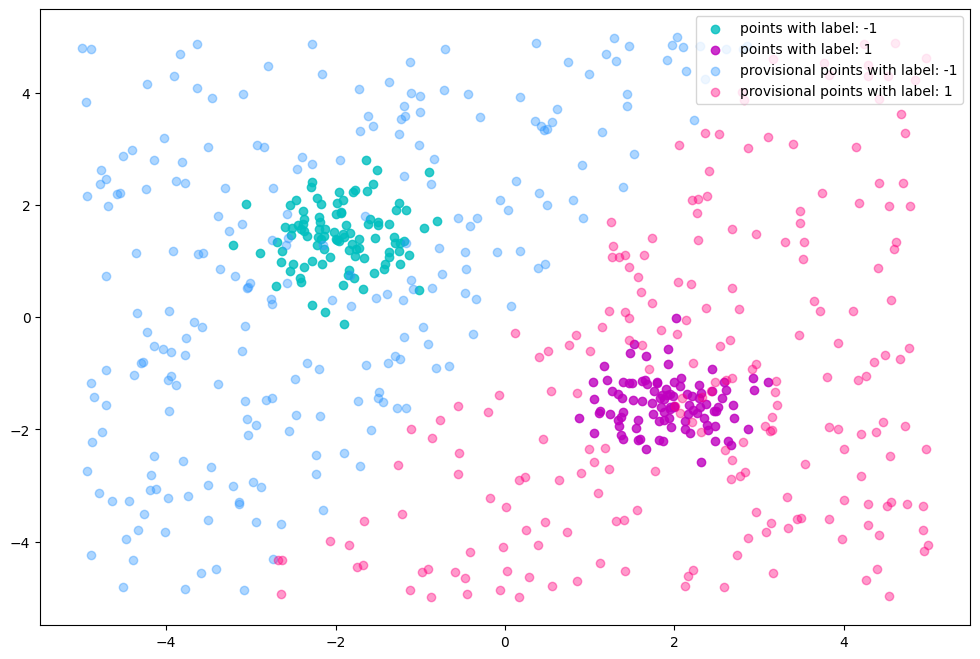

In [36]:
# Plotting all the points
pltpoints(X_label, y_label,X_unl, y_pred_R)

## *Implementation of BLOCK COORDINATE GRADIENT DESCENT with GS RULE*

***Algorithm 1 Gauss-Southwell BCGD method***

1) Choose a point $x_1 ∈ R^n$

2) For k = 1, . . .

3) If xk satisfies some specific condition, then STOP

4) Pick block $i_k$ such that 
   $ i_k = Argmax_{j∈{1,...,b}} ||∇_jf(x_k)||$.

5) Set
$x_{k+1} = x_k − \frac{1}{L} U_{i_k}∇_{i_k}||f(x_k)||$

6) End for


- **Stopping condition**: if all the components of the gradient array are below 
the tollerance (1e-10) or if we reached max iteration number (10000)

- **Step size**: fixed to $\frac{1}{L}$
- **Remark**: To run the algorithm, we need to compute the gradient at least once before starting the iterations.

First define the Gradient function to ease the process

In [41]:
def gradient_(unlabeled,y_label,W_lbl_unl,W_unl_unl):
    sum_row_label_unlabel = np.sum(W_lbl_unl, axis=0).reshape((-1,1))
    sum_row_unlabel_unlabel = np.sum(W_unl_unl, axis=0).reshape((-1,1))

    grad_first_coeff_vec = (sum_row_label_unlabel + sum_row_unlabel_unlabel)
    grad_second_coeff_vec = np.multiply(y_label.reshape((-1,1)),W_lbl_unl).sum(0).reshape((-1,1))

    unlabeled = unlabeled.reshape((-1,1))
    third_coeff = np.dot(W_unl_unl.T, unlabeled)
    
    return 2 * (grad_first_coeff_vec * unlabeled - grad_second_coeff_vec - third_coeff).reshape((-1,))

In [46]:
def BCGD_GS(W_lbl_unl,W_unl_unl,X_unl,Y,X_label,y_label,num =100):
  y_unl = np.copy(Y)
  max_iter = num*X_unl.shape[0]
  tolerance = 1e-10
  step_size = 0.3

  gradient = gradient_(y_unl,y_label,W_lbl_unl,W_unl_unl)

  loss_stack_BCGDGS =[]
  
  iter_count = 0
  y_unl = np.copy(Y)
  # Starting the algorithm
  start =timer()

  while (np.any(abs(gradient) > 091.961 -tolerance)) and (iter_count < max_iter):
    # Computing the gradient array
    iter_count +=1
    if iter_count % (10*X_unl.shape[0])== 0:
      print(f'--- iteration: {iter_count/X_unl.shape[0]}--- loss: {np.round(current_loss,3)} ---')

    
    # The number of blocks is equal to len(y_unl)
    # At each iteration, pick block i so that i = Argmax_j∈{1,...,b} ||∇jF(x_k)||
    index = np.argmax(np.abs(gradient))
      
    part1 = np.dot(2* W_lbl_unl[:,index],(y_unl[index]-y_label[:]))
    part1 = part1/norm(2* W_lbl_unl[:,index]* (y_unl[index]-y_label[:]))

    part2 = np.dot(2* W_unl_unl[:,index],(y_unl[index]-y_unl[:]))
    part2 = part2/norm(2* W_unl_unl[:][index]* (y_unl[index]-y_unl[:]))

    gradient[index] = part1 + part2

    y_unl[index] = y_unl[index] - (1/L)*gradient[index]
    if iter_count % X_unl.shape[0] == 0:
      current_loss = loss_fun(W_lbl_unl,W_unl_unl,y_label,y_unl)
      loss_stack_BCGDGS.append(current_loss)
      
    
    
  end =timer()

  exe_time_BCGD_GS = end - start 
  print(f"Time required:",exe_time_BCGD_GS)

  return y_unl,loss_stack_BCGDGS,exe_time_BCGD_GS

In [47]:
y_pred_GS,loss_stack_BCGDGS,exe_time_BCGD_GS = BCGD_GS(W_lbl_unl,W_unl_unl,X_unl,Y,X_label,y_label)

--- iteration: 10.0--- loss: -36091.961 ---
--- iteration: 20.0--- loss: -41097.66 ---
--- iteration: 30.0--- loss: -42445.921 ---
--- iteration: 40.0--- loss: -43833.242 ---
--- iteration: 50.0--- loss: -43786.799 ---
--- iteration: 60.0--- loss: -44069.253 ---
--- iteration: 70.0--- loss: -44342.131 ---
--- iteration: 80.0--- loss: -44737.868 ---
--- iteration: 90.0--- loss: -45153.385 ---
--- iteration: 100.0--- loss: -44649.969 ---
Time required: 4.0123064539984625


Convert labels to [-1, +1] and plotting the gradient behaviour

Final Loss value: -3704.117821028831



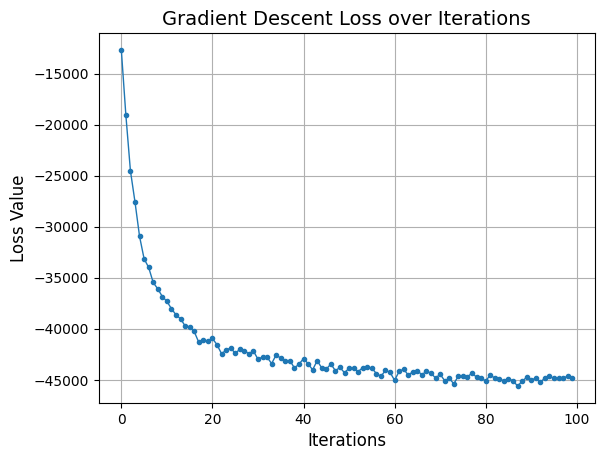

In [49]:
# Rounding labels
y_pred_GS = Rounding(y_unl)
print(f'Final Loss value: {loss_stack_BCGDR[-1]}\n')
loss_plot(loss_stack_BCGDGS[0:100])

Replot all the points to see if the algorithm works

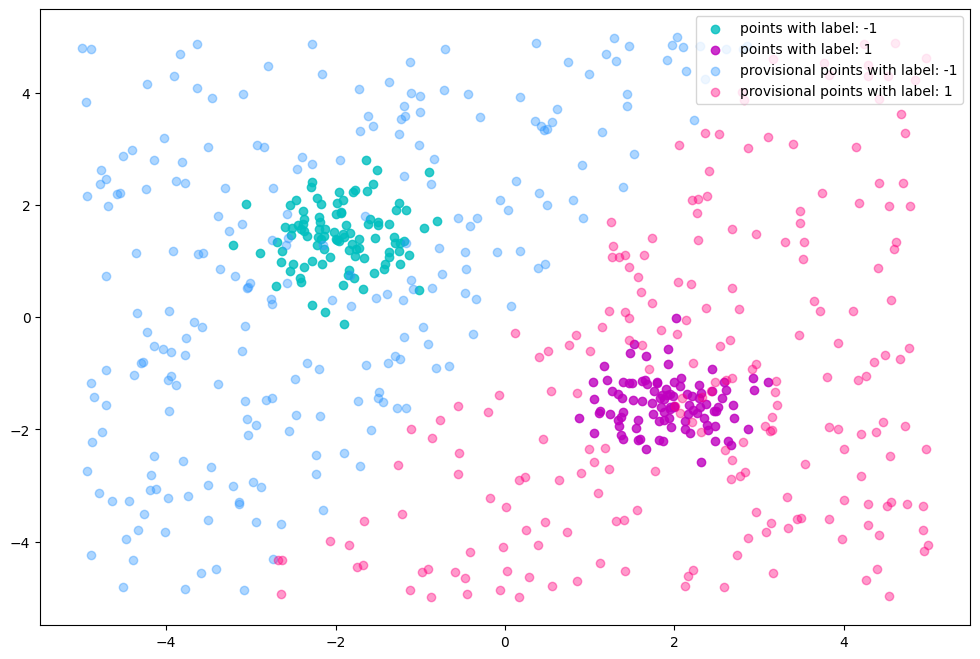

In [50]:
# Plotting all the points
pltpoints(X_label, y_label, X_unl, y_pred_GS)

## **Comparison between Randomized BCGD, Gauss-Southwell BCGD and Gradient Descent**
The time complexity, loss value, and convergence rate can vary depending on the problem and implementation details, but here are some general comparisons between randomized block coordinate gradient descent (BCGD), Gauss-Southwell block coordinate gradient descent (GS-BCGD), and standard gradient descent (GD):

Time Complexity:
BCGD and GS-BCGD have a lower time complexity per iteration compared to GD. This is because BCGD and GS-BCGD only update a subset of the variables at each iteration, while GD updates all variables. However, BCGD and GS-BCGD require more iterations to converge due to the smaller step size. In general, BCGD and GS-BCGD can be faster than GD for problems with a large number of variables and a sparse structure.

Loss Value:
The loss value convergence rate can depend on the problem and implementation details. In general, GS-BCGD can converge faster than BCGD and GD. This is because GS-BCGD uses an approximate Hessian matrix to compute the step size, which can improve convergence. However, GS-BCGD requires more computational resources to compute the Hessian approximation.

Convergence:
BCGD and GS-BCGD can converge to a suboptimal solution due to the smaller step size. However, in practice, BCGD and GS-BCGD can converge to a good solution faster than GD due to the ability to exploit the problem's structure. GD can converge to the optimal solution but requires a larger number of iterations and computational resources.

In summary, the choice between BCGD, GS-BCGD, and GD depends on the problem's structure, the availability of computational resources, and the desired trade-off between time complexity, loss value convergence rate, and convergence quality.

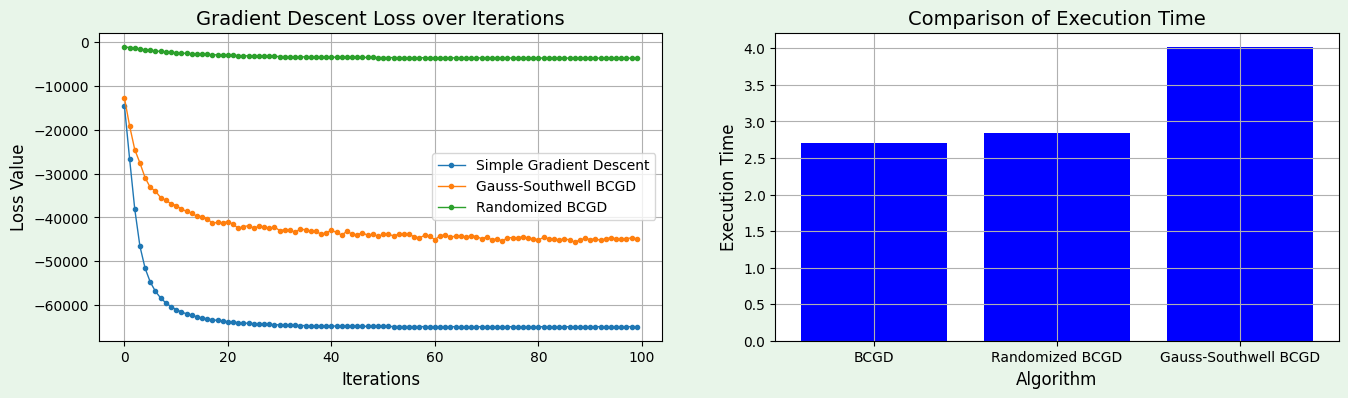

In [57]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot 1
axs[0].plot(np.arange(100), loss_stack[0:100], marker='.', linewidth=1, label='Simple Gradient Descent')
axs[0].plot(np.arange(100), loss_stack_BCGDGS[0:100], marker='.', linewidth=1, label='Gauss-Southwell BCGD')
axs[0].plot(np.arange(100), loss_stack_BCGDR[0:100], marker='.', linewidth=1, label='Randomized BCGD')

axs[0].set_xlabel('Iterations', fontsize=12)
axs[0].set_ylabel('Loss Value', fontsize=12)
axs[0].set_title('Gradient Descent Loss over Iterations', fontsize=14)
axs[0].grid(True)
axs[0].legend()
# Plot 2
axs[1].bar(['BCGD', 'Randomized BCGD', 'Gauss-Southwell BCGD'], [exe_time_GD, exe_time_BCGD, exe_time_BCGD_GS], color='blue')
axs[1].set_xlabel('Algorithm', fontsize=12)
axs[1].set_ylabel('Execution Time', fontsize=12)
axs[1].set_title('Comparison of Execution Time', fontsize=14)
axs[1].grid(True)

fig.patch.set_facecolor('#E8F5E9')


plt.show()

# Part 2

Load the dataset using Pandas framework and do preproccessing check

In [58]:
# I assume to have the .csv file saved in my desktop
from sklearn.preprocessing import StandardScaler
import io
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['breast-cancer.csv']))
df.drop('id', inplace=True, axis=1)

df.tail()

Saving breast-cancer.csv to breast-cancer.csv


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,B,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


### **Pre-processing**

In order to achieve accurate and reliable results in real datasets, it is important to standardize the data. This ensures that all features have an equal impact on the analysis and prevents the model from being skewed towards a particular feature. Additionally, dimensionality reduction techniques like Principal Component Analysis (PCA) can be applied to reduce the number of features and obtain a lower-dimensional representation of the data. In this case, PCA was used to reduce the data to 2 dimensions for better visualization and analysis.

In [59]:
# Checking for null values
print(f"Q: is there any null/missing values? A: {df.isnull().any().any()}")

# Printing the number of samples and features
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features per sample: {df.shape[1]}")

Q: is there any null/missing values? A: False
Number of samples: 569
Number of features per sample: 31


In [60]:
# Converting column "diagnosis" to [-1,+1]
convert_func = lambda x: 1 if x == 'B' else -1
df['diagnosis'] = df['diagnosis'].apply(convert_func)

df.tail()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
564,-1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,-1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,-1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,-1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
568,1,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039


In [61]:
# Extracting the dataset for classification
df_label = df.sample(frac=0.30, replace = False)
df_unlabel = df.drop(df_label.index)

In [62]:
print("Numbers of labeled data:",df_label.shape[0])
print("Numbers of unlabeled data:",df_unlabel.shape[0])

Numbers of labeled data: 171
Numbers of unlabeled data: 398


In [63]:
from sklearn.decomposition import PCA
y_label = df_label['diagnosis'].to_numpy()
df_label = df_label.drop(['diagnosis'], axis=1)
X_label = pd.DataFrame(df_label).to_numpy()

true_label = df_unlabel['diagnosis'].to_numpy()
df_unlabel = df_unlabel.drop(['diagnosis'], axis=1)

scaler = StandardScaler()
df_unlabel = scaler.fit_transform(df_unlabel)
df_label = scaler.fit_transform(df_label)

pca = PCA(n_components=2)
df_unlabel = pca.fit_transform(df_unlabel)
df_label = pca.fit_transform(df_label)

X_unl = pd.DataFrame(df_unlabel).to_numpy()
X_label = pd.DataFrame(df_label).to_numpy()


# Plot the dataset after applying PCA with true labels.

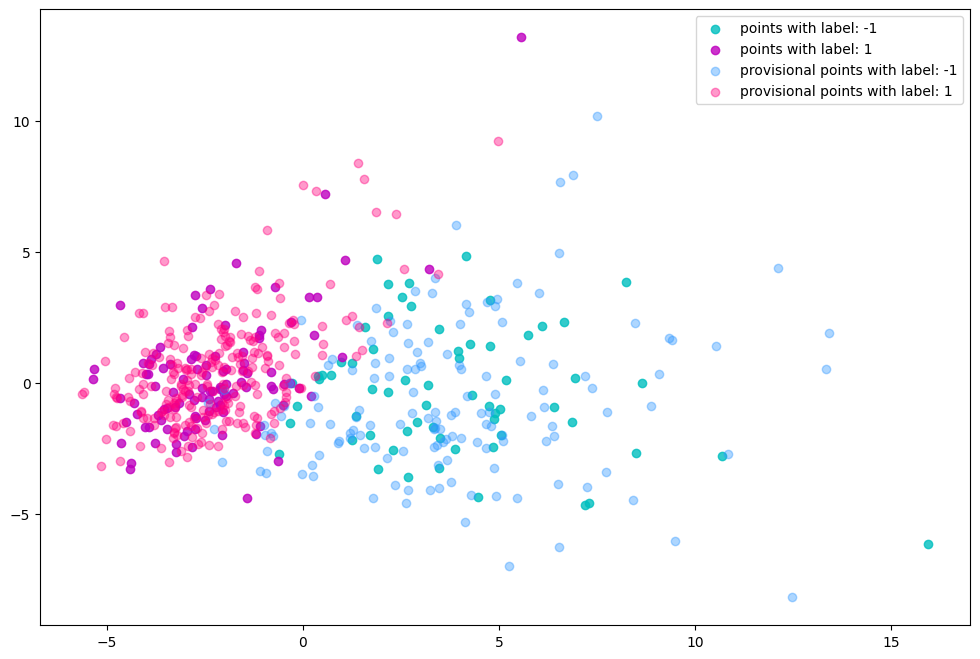

In [64]:
pltpoints(X_label, y_label, X_unl, true_label)

***Generating the similarity matrix***

In [65]:
W_unl_unl = Sim_unl_unl(X_unl)
W_lbl_unl = Sim_lbl_unl(X_label,X_unl)

***Computing the Lipschitz Constant***

In [66]:
print("Calculating the Hessian matrix")
hessian = hessianMat(W_unl_unl, W_lbl_unl)
print("\nCalculating sigma (strongly convex)")
print("\nEstimating Lipschitz constant for the whole function")
L = lipschitz_constant(hessian)
print(f"Lipschitz constant: {L}")
print("\nEstimating Lipschitz constant for each single variable")
Li = np.array([norm(hessian[i][i]) for i in range(len(hessian))], dtype='float64') 

Calculating the Hessian matrix

Calculating sigma (strongly convex)

Estimating Lipschitz constant for the whole function
Lipschitz constant: 231.64855886890962

Estimating Lipschitz constant for each single variable


***Initializing the random label for unlabeled dataset***

In [67]:
Y =generate_Y(X_unl)

In [68]:
y_pred,loss_stack,exe_time_GD = GD(W_lbl_unl,W_unl_unl,X_unl,Y,X_label,y_label)

Starting algorithm

--- iteration: 10 --- loss: -20921.22 ---
--- iteration: 20 --- loss: -34764.751 ---
--- iteration: 30 --- loss: -43679.209 ---
--- iteration: 40 --- loss: -48250.384 ---
--- iteration: 50 --- loss: -50836.847 ---
--- iteration: 60 --- loss: -52469.315 ---
--- iteration: 70 --- loss: -53580.674 ---
--- iteration: 80 --- loss: -54379.951 ---
--- iteration: 90 --- loss: -54979.008 ---
--- iteration: 100 --- loss: -55442.638 ---

Time required: 2.73133985000095


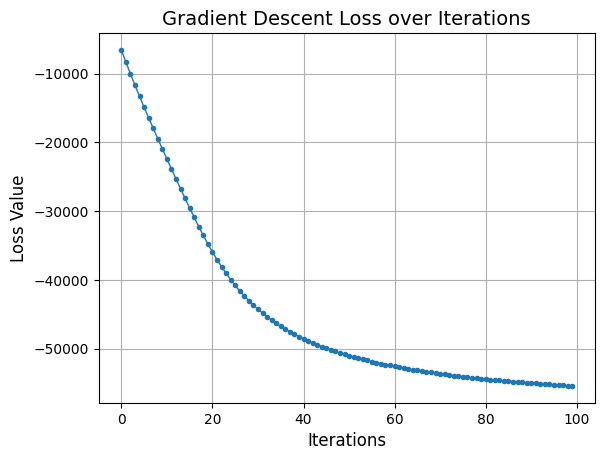

In [70]:
loss_plot(loss_stack[0:100])

In [72]:
y_pred = Rounding(y_pred)
grad_acc = Accuracy(y_pred,true_label)
print("Accuracy:",grad_acc)


Accuracy: 91.4572864321608


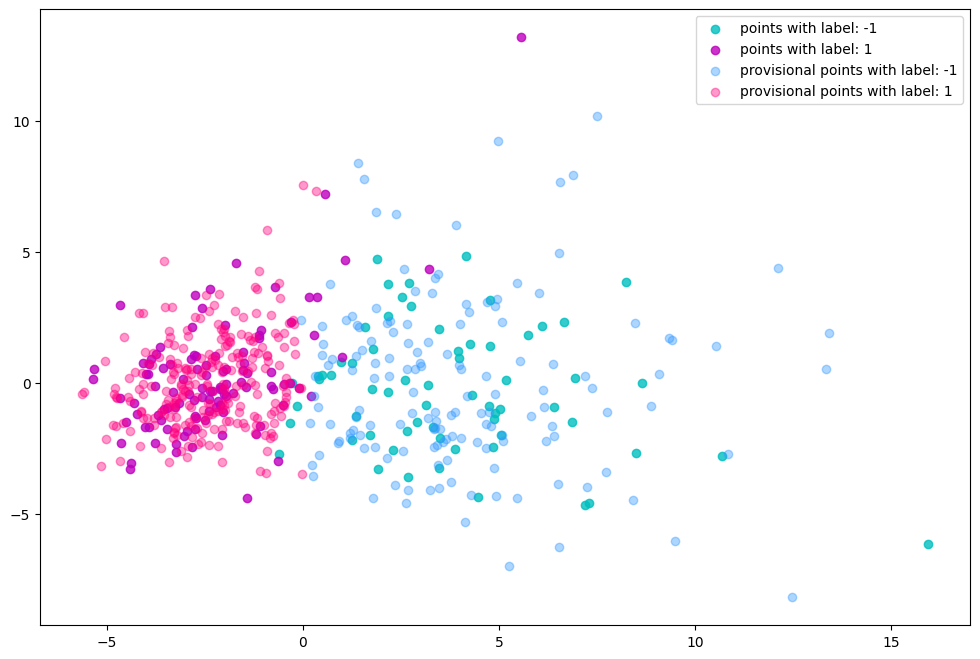

In [73]:
pltpoints(X_label, y_label, X_unl, y_pred)

In [74]:
y_pred_R,loss_stack_BCGDR,exe_time_BCGD = BCGD_R(W_lbl_unl,W_unl_unl,X_unl,Y,X_label,y_label)

--- iteration: 10 --- loss: -13237.971 ---
--- iteration: 20 --- loss: -15034.724 ---
--- iteration: 30 --- loss: -15731.631 ---
--- iteration: 40 --- loss: -15995.34 ---
--- iteration: 50 --- loss: -16110.307 ---
--- iteration: 60 --- loss: -16159.695 ---
--- iteration: 70 --- loss: -16178.185 ---
--- iteration: 80 --- loss: -16179.921 ---
--- iteration: 90 --- loss: -16172.274 ---
--- iteration: 100 --- loss: -16159.354 ---
Time required: 2.4332757310003217


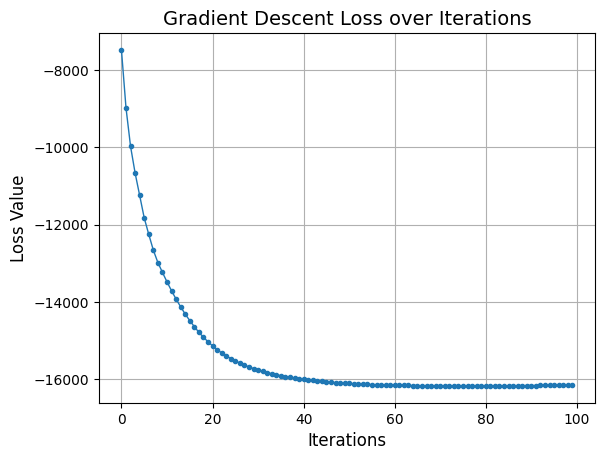

In [77]:
loss_plot(loss_stack_BCGDR[0:100])

In [78]:
y_pred_R = Rounding(y_pred_R)
BCGDR_acc = Accuracy(y_pred_R,true_label)
print("Accuracy:",BCGDR_acc)

Accuracy: 91.70854271356784


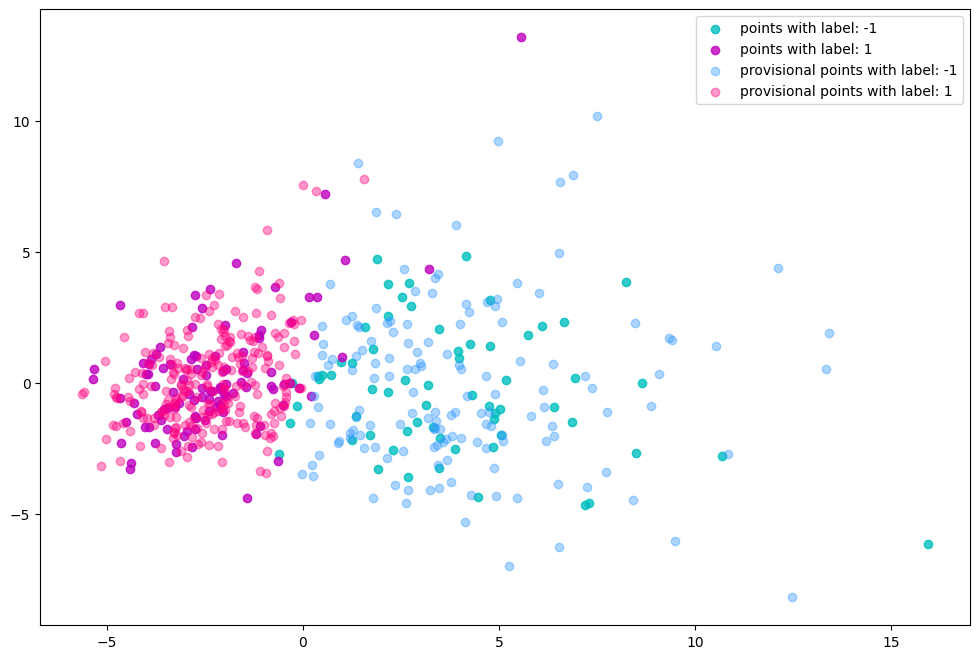

In [79]:
pltpoints(X_label, y_label, X_unl, y_pred_R)

In [80]:
y_pred_GS,loss_stack_BCGDGS,exe_time_BCGD = BCGD_GS(W_lbl_unl,W_unl_unl,X_unl,Y,X_label,y_label)

--- iteration: 10.0--- loss: -23072.259 ---
--- iteration: 20.0--- loss: -26494.867 ---
--- iteration: 30.0--- loss: -27584.287 ---
--- iteration: 40.0--- loss: -28137.966 ---
--- iteration: 50.0--- loss: -28259.973 ---
--- iteration: 60.0--- loss: -28421.496 ---
--- iteration: 70.0--- loss: -28365.45 ---
--- iteration: 80.0--- loss: -28529.865 ---
--- iteration: 90.0--- loss: -28500.781 ---
--- iteration: 100.0--- loss: -28504.558 ---
Time required: 3.2889487210013613


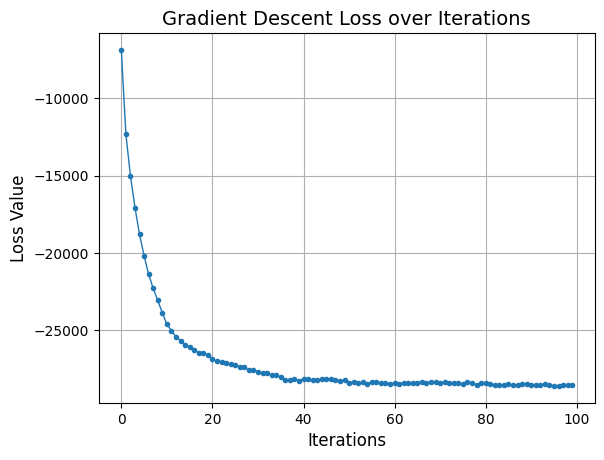

In [82]:
loss_plot(loss_stack_BCGDGS[0:100])

In [84]:
y_pred_GS = Rounding(y_pred_GS)
BCGDGS_acc = Accuracy(y_pred_GS,true_label)
print("Accuracy:",BCGDGS_acc)

Accuracy: 70.10050251256281


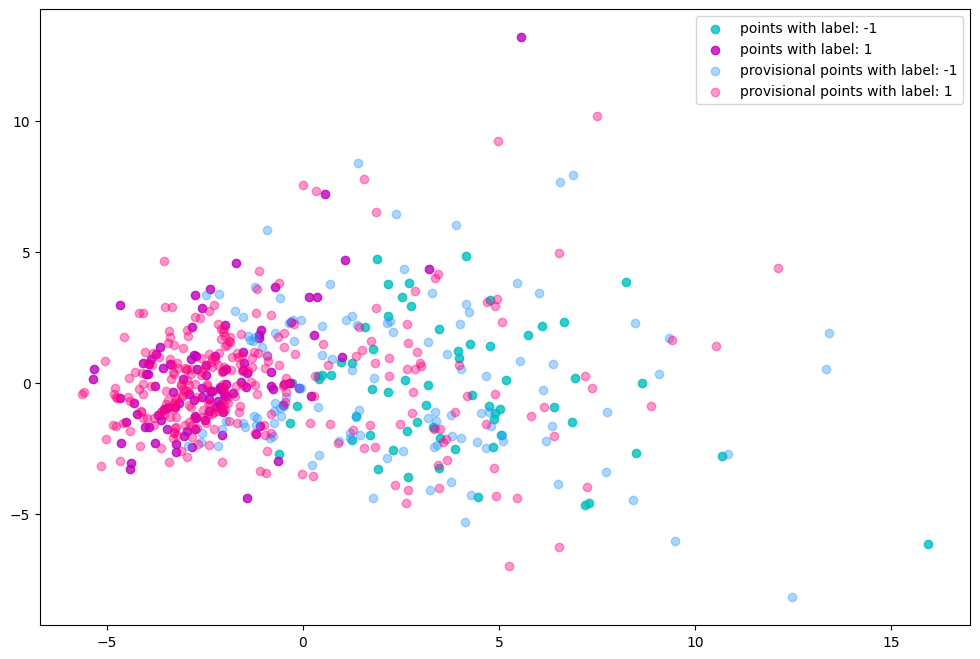

In [85]:
pltpoints(X_label, y_label, X_unl, y_pred_GS)

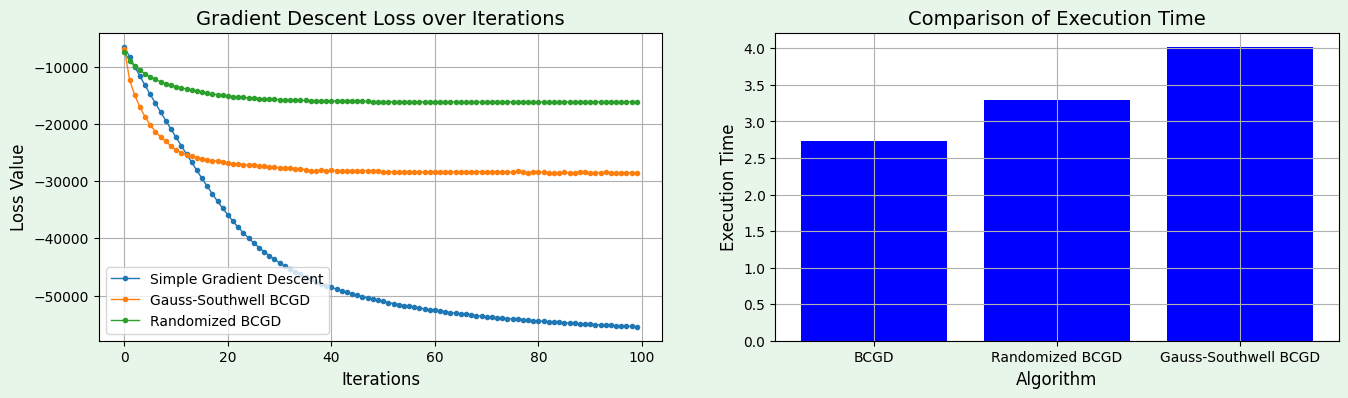

In [86]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# Plot 1
axs[0].plot(np.arange(100), loss_stack[0:100], marker='.', linewidth=1, label='Simple Gradient Descent')
axs[0].plot(np.arange(100), loss_stack_BCGDGS[0:100], marker='.', linewidth=1, label='Gauss-Southwell BCGD')
axs[0].plot(np.arange(100), loss_stack_BCGDR[0:100], marker='.', linewidth=1, label='Randomized BCGD')

axs[0].set_xlabel('Iterations', fontsize=12)
axs[0].set_ylabel('Loss Value', fontsize=12)
axs[0].set_title('Gradient Descent Loss over Iterations', fontsize=14)
axs[0].grid(True)
axs[0].legend()
# Plot 2
axs[1].bar(['BCGD', 'Randomized BCGD', 'Gauss-Southwell BCGD'], [exe_time_GD, exe_time_BCGD, exe_time_BCGD_GS], color='blue')
axs[1].set_xlabel('Algorithm', fontsize=12)
axs[1].set_ylabel('Execution Time', fontsize=12)
axs[1].set_title('Comparison of Execution Time', fontsize=14)
axs[1].grid(True)

fig.patch.set_facecolor('#E8F5E9')


plt.show()

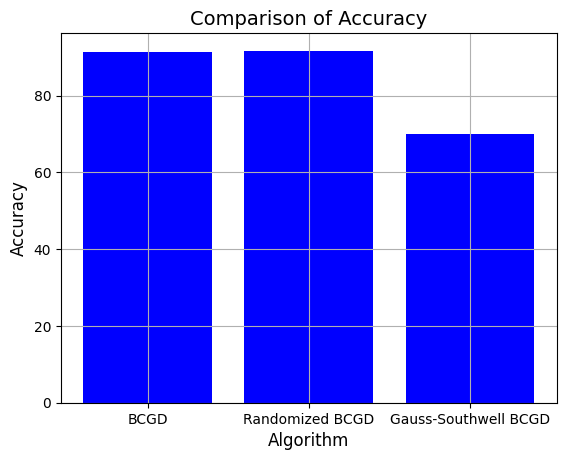

In [92]:
plt.bar(['BCGD', 'Randomized BCGD', 'Gauss-Southwell BCGD'], [grad_acc, BCGDR_acc, BCGDGS_acc], color='blue')
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Comparison of Accuracy', fontsize=14)
plt.grid(True)
plt.show()